In [121]:
import re
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import nltk
from nltk.stem import PorterStemmer

def goodRating(row):
    return row >= 3

def avgSentiment(row, w_dict):
    s = 0
    tokens = row.split()
    for t in tokens:
         s += w_dict[t]
    return s/len(tokens)

def avgSentiment(row, w_dict):
    s = 0
    count = 0
    tokens = row.split()
    for t in tokens:
        try:
            s += w_dict[t]
            count += 1
        except:
            continue
    return s/count

def posWords(row, w_dict):
    numWords = 0
    tokens = row.split()
    for t in tokens:
        try: 
            if w_dict[t] > 0:
                numWords += 1
        except:
            continue
    return numWords

def negWords(row, w_dict):
    numWords = 0
    tokens = row.split()
    for t in tokens:
        try: 
            if w_dict[t] < 0:
                numWords += 1
        except:
            continue
    return numWords

# Porter stemmer for text stemming
porter = PorterStemmer()

stop = ["i", "me", "my", "myself", "we", "our", "ours", "ourselves", 
        "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", 
        "she", "her", "hers", "herself", "it", "its", "itself", "they", 
        "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", 
        "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", 
        "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", 
        "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", 
        "for", "with", "about", "against", "between", "into", "through", "during", "before", 
        "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", 
        "over", "under", "again", "further", "then", "once", "here", "there", "when", 
        "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", 
        "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", 
        "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"]

def avg_word(sentence):
    words = sentence.split()
    return (sum(len(word) for word in words)/len(words))

data = pd.read_csv("beer.csv")
data.drop('index',axis =1, inplace = True)
newCols = [col.split('/')[1] for col in data.columns]
data = pd.DataFrame(data.values, columns = newCols).drop(['beerId','brewerId'], axis = 1)

train = data
# Additional featureW
train['word_count'] = train['text'].apply(lambda x: len(str(x).split(" ")))
train['char_count'] = train['text'].str.len() ## this also includes spaces
train['avg_word_len'] = train['text'].apply(lambda x: avg_word(str(x)))
train['stopwords'] = train['text'].apply(lambda x: len([x for x in str(x).split() if x in stop]))
train['questions'] = train['text'].apply(lambda x: len([x for x in str(x).split() if '?' in str(x)]))
train['ellipses'] = train['text'].apply(lambda x: len([x for x in str(x).split() if '...' in str(x)]))
train['numerics'] = train['text'].apply(lambda x: len([x for x in str(x).split() if x.isdigit()]))
train['upper'] = train['text'].str.findall(r'[A-Z]').str.len()
# Convert reviews to lower case
train['text'] = train['text'].apply(lambda x: " ".join(x.lower() for x in str(x).split()))

# Remove punctuation characters from  text review
train['text'] = train['text'].str.replace('[^\w\s]','')
# Remove stop words
train['text'] = train['text'].apply(lambda x: " ".join(x for x in str(x).split() if x not in stop))


In [122]:
# Stem words
train['text'] = train['text'].apply((lambda x: " ".join(porter.stem(x) for x in str(x).split())))

# Remove least frequent words
l_freq = pd.Series(' '.join(train['text']).split()).value_counts()[-10:]
l_freq = list(l_freq.index)
train['text'] = train['text'].apply(lambda x: " ".join(x for x in str(x).split() if x not in l_freq))

# Label beer ratings as positive or negative
train['target'] = train['overall'].apply(goodRating)
train.sort_values(by = 'overall', ascending = False, inplace = True)

In [123]:
text_train = train['text'].values
target = train['target'].values

In [124]:
#Vectorize words from beer rating text
cv = CountVectorizer(binary=True)
cv.fit(text_train)
X = cv.transform(text_train)
#X_test = cv.transform(reviews_test_clean)


In [125]:
X_train, X_val, y_train, y_val = train_test_split(
    X, target, train_size = 0.75
)

c_values = np.linspace(.01,1,100)
accuracy = []
for c in c_values:
    lr = LogisticRegression(C=c, solver='liblinear')
    lr.fit(X_train, y_train)
    
    #print ("Accuracy for C=%s: %s" 
          # % (c, accuracy_score(y_val, lr.predict(X_val))))
    accuracy.append(accuracy_score(y_val, lr.predict(X_val)))
    

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Best C Value: 0.11


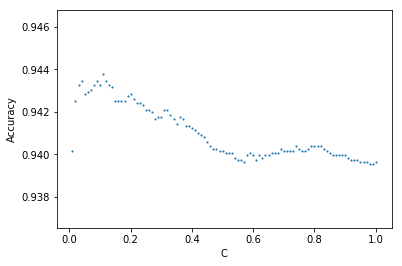

In [134]:
# Optimize the C hyperparameter for regularization 
import matplotlib.pyplot as plt
fig = plt.figure()
plt.scatter(c_values, accuracy, s = 1.2)
plt.ylabel('Accuracy')
plt.xlabel('C')
best_c = c_values[accuracy.index(max(accuracy))]
print('Best C Value:', best_c)

In [127]:
final_model = LogisticRegression(C = best_c, solver = 'liblinear')
final_model.fit(X, target)

LogisticRegression(C=0.11, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [128]:
feature_to_coef = {
    word: coef for word, coef in zip(
        cv.get_feature_names(), final_model.coef_[0]
    )
}
for best_positive in sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1], 
    reverse=True)[:5]:
    print (best_positive)

('easi', 1.2179528193737079)
('awesom', 0.81446689155647756)
('tasti', 0.75022752469534348)
('smooth', 0.7410331909450244)
('rye', 0.72522144798559907)


In [129]:
for best_negative in sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1])[:5]:
    print (best_negative)

('drain', -1.1470296588997257)
('drainpour', -0.99043941846891048)
('worst', -0.86970686039451506)
('chemic', -0.85852458072533711)
('aw', -0.85588310238738952)


In [130]:
def avgSentiment(row, w_dict):
    s = 0
    count = 0
    tokens = row.split()
    for t in tokens:
        try:
            s += w_dict[t]
            count += 1
        except:
            continue
    return s/count

def posWords(row, w_dict):
    numWords = 0
    tokens = row.split()
    for t in tokens:
        try: 
            if w_dict[t] > 0:
                numWords += 1
        except:
            continue
    return numWords

def negWords(row, w_dict):
    numWords = 0
    tokens = row.split()
    for t in tokens:
        try: 
            if w_dict[t] < 0:
                numWords += 1
        except:
            continue
    return numWords
    

In [131]:
train['avg_sent'] = train['text'].apply(avgSentiment, args = (feature_to_coef,))
train['#pos_words'] = train['text'].apply(posWords, args = (feature_to_coef,))
train['#neg_words'] = train['text'].apply(negWords, args = (feature_to_coef,))
train['#pos/#neg'] = train['#pos_words']/train['#neg_words']
# Some values turn to infinite due to 0 divison, its fixed below
mask = train['#pos/#neg'] != np.inf
train.loc[~mask, '#pos/#neg'] = 1

In [133]:
train.sort_values(by = '#pos/#neg', ascending = False)

,ABV,name,style,appearance,aroma,overall,palate,taste,text,timeStruct,...,stopwords,questions,ellipses,numerics,upper,target,avg_sent,#pos_words,#neg_words,#pos/#neg
23705,7.4,TÃ©mÃ©raire,Old Ale,3.5,3.5,4,3.5,3.5,pour darkish moder head easi drink old ale com...,"{'min': 44, 'hour': 3, 'mday': 24, 'sec': 1, '...",...,16,0,0,0,6.0,True,0.148992,24,1,24.000000
36263,9.4,B.O.R.I.S. The Crusher Oatmeal-Imperial Stout,Russian Imperial Stout,4,4.5,4.5,4.5,5,black head small brown ring around edg dark fr...,"{'min': 19, 'hour': 22, 'mday': 30, 'sec': 51,...",...,7,0,0,0,17.0,True,0.204372,31,2,15.500000
23288,6.5,Founders Porter,American Porter,4,4.5,4.5,4.5,4.5,dark brown nearli black 0ne finger mocha head ...,"{'min': 49, 'hour': 21, 'mday': 18, 'sec': 5, ...",...,8,0,0,0,6.0,True,0.199100,27,2,13.500000
1449,5.8,Pilot Rock Porter,American Porter,4.5,4,5,4,4,wonder fluffi full head porter great esspresso...,"{'min': 58, 'hour': 4, 'mday': 8, 'sec': 46, '...",...,9,0,0,0,4.0,True,0.150340,26,2,13.000000
35917,4.9,Weltenburger Pils,German Pilsener,4.5,3.5,4,4.5,4,wonder pour nice foam tight bubbl golden tint ...,"{'min': 38, 'hour': 1, 'mday': 13, 'sec': 21, ...",...,26,0,0,0,0.0,True,0.163959,38,3,12.666667
33631,9.4,B.O.R.I.S. The Crusher Oatmeal-Imperial Stout,Russian Imperial Stout,4,4.5,4.5,5,4.5,pour deep dark black creami tan head fade fast...,"{'min': 55, 'hour': 2, 'mday': 21, 'sec': 44, ...",...,27,0,0,0,6.0,True,0.182613,51,5,10.200000
27572,6.9,Terminal Gravity IPA,American IPA,3.5,4,3.5,4,4,pour cloudi orang colornos big canibusalso bis...,"{'min': 5, 'hour': 6, 'mday': 14, 'sec': 25, '...",...,27,0,9,0,9.0,True,0.054864,40,4,10.000000
36648,6.6,Founders Red's Rye PA,Rye Beer,4,4.5,4.5,4,4,darkish copper color big offwhit head lot citr...,"{'min': 58, 'hour': 17, 'mday': 29, 'sec': 28,...",...,37,0,0,0,14.0,True,0.214395,39,4,9.750000
29520,8.3,Founders Breakfast Stout,American Double / Imperial Stout,4,4.5,3,4.5,5,pour thick blackwith nice tan head great aroma...,"{'min': 48, 'hour': 2, 'mday': 5, 'sec': 21, '...",...,17,0,0,0,1.0,True,0.157125,29,3,9.666667
1122,6,Black IPA,American Black Ale,4,4,4.5,4.5,4,pour decent dark brown nice head good lace nic...,"{'min': 11, 'hour': 21, 'mday': 3, 'sec': 22, ...",...,13,0,0,0,4.0,True,0.190219,27,3,9.000000
